In [23]:
# from IPython import parallel
# rc = parallel.Client()
# dv = rc[:]
# rc.ids

[0, 1, 2, 3]

In [1]:
#%%px --local 
import os
import sys
sys.path.append(os.environ['HOME']+'/home/proj/stats/MCMC')
os.environ['PYTHONPATH'] = os.environ['HOME']+'/home/proj/stats/MCMC'

import csv

import matplotlib.pyplot as plt
import numpy as np
import scipy as sp

#%matplotlib inline
import model
import driver
import data

min Temp = 3.000000 K; max Temp = 100.000000 K


In [3]:
### read the file of fluxes and errors
### could make a numpy record array instead of separate ones for name, z, err, flux?
### nb. this version has the same length for each row

herus_file = "herus_phot.csv"
herus_file = "herus_phot_csv.csv"


speed_of_light = 299792.458 ### micron GHz

def toFloat(s):
    return np.float(s) if s!='' else np.nan

names = []
zarr = []
fluxes = []
errs = []
with open(herus_file, "rb") as csvfile:
    hreader = csv.reader(csvfile)
    headers = hreader.next()
    ncol = len(headers)
    name_column = headers=='Name'
    z_column = headers=='Redshift'
    flux_columns = [i for i in range(ncol) if headers[i].startswith('F')]
    err_columns = [i for i in range(ncol) if headers[i].startswith('E')]
    lambdas = speed_of_light/np.array([float(headers[i].split('_')[0][1:]) for i in flux_columns])  ### lambda in um
    lambdas_err = speed_of_light/np.array([float(headers[i].split('_')[0][1:]) for i in flux_columns])
    assert(np.all(lambdas==lambdas_err))   ### check correct order
    
    for row in hreader:
        names.append(row[name_column])
        zarr.append(row[z_column])
        fluxes.append([toFloat(row[c]) for c in flux_columns])
        errs.append([toFloat(row[c]) for c in err_columns])


In [4]:
### read the file of fluxes and errors
### could make a numpy record array instead of separate ones for name, z, err, flux?
### nb. this version deletes nonexistent entries, but puts err=np.nan if there is a flux but no entry
#### used in driver.py: readfluxes_DLC_2014
import re
Epat = r'^E\d+_'
Fpat = r'^F\d+_'
UL25 = True
fluxes = []
errs = []
names = []
zarr = []
with open(herus_file, "rb") as csvfile:
    hreader = csv.reader(csvfile)
    headers = np.array(hreader.next())
    ncol = len(headers)
    name_column = np.where(headers=='Name')[0][0]
    z_column = np.where(headers=='Redshift')[0][0]
    flux_columns = np.array([i for i in range(ncol) if re.match(Fpat, headers[i])])
    err_columns = np.array([i for i in range(ncol) if re.match(Epat, headers[i])])
    assert np.all(err_columns == flux_columns+1)

    lambda_obs = np.array([float(headers[i].split('_')[0][1:]) for i in flux_columns])  ### Freq in GHz
    lambda_err = np.array([float(headers[i].split('_')[0][1:]) for i in flux_columns])
    assert(np.all(lambda_obs==lambda_err))   ### check correct order
    
    for row in hreader:
        row = np.asarray(row)
        if np.all(row==''): continue  ## ignore blank lines
        z = np.float(row[z_column])
        dat = zip(row[flux_columns], row[err_columns], lambda_obs)
        dat_compressed = np.array([[np.float(f), toFloat(e), l] for f,e,l in dat if f!=''])
        #flux = np.array([np.float(c) for c in row[flux_columns] if c!=''])
        #err = np.array([np.float(c) for c in row[err_columns] if c!=''])
        flux = np.array(dat_compressed[:,0])
        sig = np.array(dat_compressed[:,1])
        lambda_obs_1 = np.array(dat_compressed[:,2])
        
        nu_obs = speed_of_light/lambda_obs_1
        if UL25:
            l25 = np.where(np.round(lambda_obs_1)==25)[0]
            if l25:
                sig[l25] = flux[l25]
                flux[l25] = 0

        nu_rest = nu_obs*(1+z)

        names.append(row[name_column])
        zarr.append(z)
        fluxes.append(flux)
        errs.append(sig)

elens = [len(e) for e in errs]


In [63]:
herus_file = "august6table.csv"
speed_of_light = 299792.458 ### micron GHz

reload(data)
d = data.readfluxes_DLC_2014(filename=herus_file, del157=True)
# d1 = d[1]
# print [di.name for di in d]
# print d[-3].name, d[-3].d, d[-3].z
# print d[-1].name, d[-1].d, d[-1].z
if np.where(np.round(speed_of_light/d[-8].freq_obs)==160)[0]: print "found"
print  np.where(np.round(speed_of_light/d[-8].freq_obs)==160)[0]

IRAS05189-2524 deleting 157 micron
IRAS08572+3915 deleting 157 micron
IRAS09022-3615 deleting 157 micron
IRAS10565+2448 deleting 157 micron
IRAS13120-5453 deleting 157 micron
IRAS13451+1232 deleting 157 micron
IRAS14348-1447 deleting 157 micron
IRAS14378-3651 deleting 157 micron
IRAS15250+3609 deleting 157 micron
IRAS17208-0014 deleting 157 micron
IRAS19297-0406 deleting 157 micron
IRAS20551-4250 deleting 157 micron
IRAS22491-1808 deleting 157 micron
IRAS23128-5919 deleting 157 micron
IRAS23365+3604 deleting 157 micron
Mrk1014 deleting 157 micron
UGC5101 deleting 157 micron
Mrk273 deleting 157 micron
Arp220-short deleting 157 micron
NGC6240 deleting 157 micron
[0]


Populating the interactive namespace from numpy and matplotlib
IRAS09022-3615


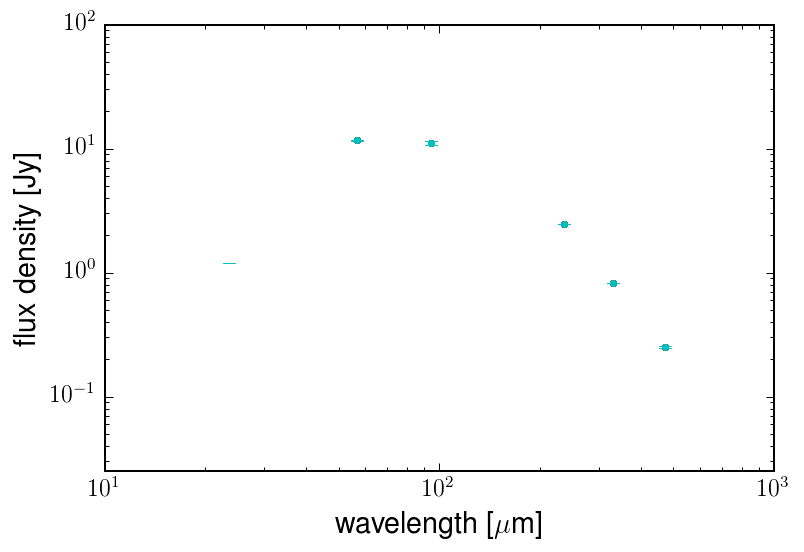

In [12]:
%pylab inline
herus_file = "herus_phot_csv.csv"

herus_file = "herus_phot.csv"

speed_of_light = 299792.458 ### micron GHz
reload(data)
d = data.readfluxes_DLC_2014(filename=herus_file)
dm1 = d[11]
print dm1.name
# np.sort((data.speed_of_light/dm1.freq))
# len(dm1.d)
plt.loglog(speed_of_light/dm1.freq, dm1.d, '.')
plt.errorbar(speed_of_light/dm1.freq, dm1.d, dm1.sig, fmt='.')
dm1.plot(dm1.name, wavelength=True, fmt='.', logplot=True)

In [ ]:
#%matplotlib osx
%run driver.py --format=DLC_2014 --fdir=./figs_DLC_2014_2 --odir=./out_DLC_2014_2 --file=./herus_phot.csv 0 1 2 3

In [2]:
#%%px --noblock
%run driver.py --format=DLC_2014 --fdir=./figs_DLC_2014_2 --odir=./out_DLC_2014_2 --file=./herus_phot.csv 0

/Volumes/Data/Users/jaffe/Library/Python/2.7/lib/python/site-packages/matplotlib-1.3.1-py2.7-macosx-10.6-intel.egg/matplotlib/__init__.py:1155: UserWarning:  This call to matplotlib.use() has no effect
because the backend has already been chosen;
matplotlib.use() must be called *before* pylab, matplotlib.pyplot,
or matplotlib.backends is imported for the first time.

  warnings.warn(_use_error_msg)


normal behaviour
filename: ./herus_phot.csv
fig dir: ./figs_DLC_2014_2/
out dir: ./out_DLC_2014_2/
data range None
DLC_UL = 1
format = 0
filetype = DLC_2014
which= [0]
Using file ./herus_phot.csv
keywords: {'random': True, 'randomrestart': True, 'filetype': 'DLC_2014', 'format': 0, 'DLC_ul': True}
Two-Component beta = 2
Object[s] IRAS00188-0856(z=0.128)
Number of prior resamples: 2
done with chain 0. naccept=5202 (0.346777)

100% |########################################################################|
100% |########################################################################|



per block:  [   8 2501   90   16 2501   91]
Number of prior resamples: 213
done with chain 1. naccept=200161 (0.667201)
per block:  [ 1468 50001  1070 49999 50001 47627]
chi2 at max = 23.960476
Max ln likelihood -11.980238 at parameters:
[   0.11958923    2.           31.6869833  -108.35336389    2.
   42.34247664]
            \log A_1 mean = 0.115103 +- 0.0432487
                 T_1 mean = 31.8705 +- 1.58634
            \log A_2 mean = -59.1526 +- 22.238
                 T_2 mean = 65.4563 +- 19.4743
ln Pr of mean = -12.250167
chi2(mean) = 24.500333
Object[s] IRAS00397-1312(z=0.262)

100% |########################################################################|



done with chain 0. naccept=8828 (0.588494)

100% |########################################################################|
100% |########################################################################|



per block:  [2300 2501 1499    9 2501   23]
done with chain 1. naccept=236271 (0.787567)
per block:  [49971 50001 44661 12544 50001 29098]
chi2 at max = 11.697852
Max ln likelihood -5.848926 at parameters:
[ -1.9356365    2.          34.72607573  -0.67132276   2.          42.47053231]
            \log A_1 mean = -11760 +- 5001.49
                 T_1 mean = 22.715 +- 11.3212
            \log A_2 mean = -0.643731 +- 0.0493647
                 T_2 mean = 41.9423 +- 1.5708
ln Pr of mean = -6.022750
chi2(mean) = 12.045499
Object[s] IRAS01003-2238(z=0.118)

100% |########################################################################|



done with chain 0. naccept=9503 (0.633491)

100% |########################################################################|
100% |########################################################################|



per block:  [2474 2501 1920   14 2501   98]
Number of prior resamples: 16
done with chain 1. naccept=206000 (0.686664)
per block:  [49806 50001 41807  5472 50001  8918]
chi2 at max = 2.705686
Max ln likelihood -1.352843 at parameters:
[ -2.00920507   2.          31.02827203  -0.80349325   2.          45.0750897 ]
            \log A_1 mean = -5067.89 +- 4584.43
                 T_1 mean = 23.6373 +- 12.0467
            \log A_2 mean = -0.787713 +- 0.0184037
                 T_2 mean = 44.8595 +- 0.828058
ln Pr of mean = -1.390887
chi2(mean) = 2.781773
Object[s] IRAS03158+4227(z=0.134)

100% |########################################################################|



Number of prior resamples: 7
done with chain 0. naccept=9811 (0.654023)

100% |########################################################################|
100% |########################################################################|



per block:  [  18 2501   27 2497 2501 2272]
done with chain 1. naccept=132461 (0.441535)
per block:  [  259 50001  3101 15056 50001 14048]
chi2 at max = 29.173054
Max ln likelihood -14.586527 at parameters:
[  0.27708598   2.          27.35767051  -1.5866489    2.          68.77885618]
            \log A_1 mean = 0.461361 +- 0.192033
                 T_1 mean = 24.0311 +- 2.88674
            \log A_2 mean = -484.486 +- 898.706
                 T_2 mean = 69.4807 +- 14.6528
ln Pr of mean = -125.142726
chi2(mean) = 250.285452
Object[s] IRAS03521+0028(z=0.152)

100% |########################################################################|



done with chain 0. naccept=5196 (0.346377)

100% |########################################################################|
100% |########################################################################|



per block:  [  14 2501  144    3 2501   38]
done with chain 1. naccept=159644 (0.532145)
per block:  [26443 50001 11772  5575 50001 15857]
chi2 at max = 0.021230
Max ln likelihood -0.010615 at parameters:
[  0.43393546   2.          11.64795548  -0.22480234   2.          38.07681331]
            \log A_1 mean = 0.454932 +- 0.280938
                 T_1 mean = 11.8827 +- 2.84225
            \log A_2 mean = -0.222166 +- 0.0380794
                 T_2 mean = 37.869 +- 0.913049
ln Pr of mean = -1.840032
chi2(mean) = 3.680065
Object[s] IRAS05189-2524(z=0.043)

100% |########################################################################|



Number of prior resamples: 5
done with chain 0. naccept=5069 (0.337911)

100% |########################################################################|
100% |########################################################################|



per block:  [  15 2501   30    7 2501   20]
done with chain 1. naccept=104837 (0.349456)
per block:  [  353 50001  3309   361 50001   817]
chi2 at max = 30.364782
Max ln likelihood -15.182391 at parameters:
[  0.51905197   2.          28.71931567  -0.40037455   2.          50.74844815]
            \log A_1 mean = 0.528433 +- 0.0531746
                 T_1 mean = 28.4128 +- 1.0239
            \log A_2 mean = -0.388282 +- 0.0123816
                 T_2 mean = 50.5869 +- 0.32503
ln Pr of mean = -16.089968
chi2(mean) = 32.179936
Object[s] IRAS06035-7102(z=0.079)

100% |########################################################################|



done with chain 0. naccept=9447 (0.629758)


100% |########################################################################|



per block:  [2440 2501 1960   15 2501   35]
done with chain 1. naccept=189883 (0.632941)
per block:  [49810 50001 39143   435 50001   498]
chi2 at max = 56.578722
Max ln likelihood -28.289361 at parameters:
[ -5.46509766e+03   2.00000000e+00   1.77059830e+01   1.47798881e-01
   2.00000000e+00   3.63324307e+01]
            \log A_1 mean = -5267.24 +- 3776.79
                 T_1 mean = 19.5924 +- 9.65681
            \log A_2 mean = 0.14781 +- 0.00352328
                 T_2 mean = 36.3341 +- 0.10284
ln Pr of mean = -28.285365
chi2(mean) = 56.570731
Object[s] IRAS06206-6315(z=0.092)

100% |########################################################################|



done with chain 0. naccept=9308 (0.620492)

100% |########################################################################|
100% |########################################################################|



per block:  [2487 2501 1796    5 2501   23]
done with chain 1. naccept=195525 (0.651748)
per block:  [49729 50001 41054   406 50001  4339]
chi2 at max = 100.857067
Max ln likelihood -50.428534 at parameters:
[ -1.47504222   2.          11.41587115   0.25874588   2.          33.43337096]
            \log A_1 mean = -4435.8 +- 3638.8
                 T_1 mean = 18.0485 +- 8.65214
            \log A_2 mean = 0.270922 +- 0.0383887
                 T_2 mean = 33.0403 +- 1.17325
ln Pr of mean = -53.301520
chi2(mean) = 106.603040
Object[s] IRAS07598+6508(z=0.148)

100% |########################################################################|



done with chain 0. naccept=8930 (0.595294)

100% |########################################################################|
100% |########################################################################|



per block:  [2465 2501 1427   13 2501   28]
done with chain 1. naccept=217252 (0.724171)
per block:  [49937 50001 44752  1278 50001 21288]
chi2 at max = 39.276845
Max ln likelihood -19.638423 at parameters:
[ -8.41062879e+03   2.00000000e+00   7.82479355e+00  -2.59699817e-01
   2.00000000e+00   3.56066778e+01]
            \log A_1 mean = -7915.7 +- 3594.3
                 T_1 mean = 18.6324 +- 9.34564
            \log A_2 mean = -0.226661 +- 0.125409
                 T_2 mean = 34.7447 +- 3.12435
ln Pr of mean = -26.457693
chi2(mean) = 52.915385
Object[s] IRAS08311-2459(z=0.100)

100% |########################################################################|



Number of prior resamples: 28
done with chain 0. naccept=5254 (0.350243)

100% |########################################################################|
100% |########################################################################|



per block:  [  22 2501  108   16 2501  111]
done with chain 1. naccept=103631 (0.345436)
per block:  [  396 50001   856   899 50001  1483]
chi2 at max = 2.571217
Max ln likelihood -1.285608 at parameters:
[  0.1499183    2.          25.99944821  -0.15839177   2.          39.61186553]
            \log A_1 mean = 0.108206 +- 0.0409967
                 T_1 mean = 30.4994 +- 3.0882
            \log A_2 mean = -0.276059 +- 0.0792624
                 T_2 mean = 38.5622 +- 1.81351
ln Pr of mean = -7.747469
chi2(mean) = 15.494938
Object[s] IRAS08572+3915(z=0.058)

100% |########################################################################|



Number of prior resamples: 2
done with chain 0. naccept=9583 (0.638824)

100% |########################################################################|
100% |########################################################################|
model.py:418: RuntimeWarning: overflow encountered in double_scalars
  self.A1 = 10.0**logA1
/Volumes/Data/Users/jaffe/home/proj/stats/MCMC/GaussianData.py:47: RuntimeWarning: overflow encountered in true_divide
  return dot(A.transpose()/self.sig2,A)



per block:  [2465 2501 2077   16 2501   28]
done with chain 1. naccept=191052 (0.636838)
per block:  [49811 50001 39175   636 50001  1433]
chi2 at max = 20.223359
Max ln likelihood -10.111679 at parameters:
[  0.95227577   2.           4.59825771  -0.37998152   2.          46.37031234]
            \log A_1 mean = -12436.2 +- 8672.96
                 T_1 mean = 24.9921 +- 12.5648
            \log A_2 mean = -0.37989 +- 0.00986489
                 T_2 mean = 46.393 +- 0.214217
ln Pr of mean = -10.836421
chi2(mean) = 21.672841
Object[s] IRAS09022-3615(z=0.060)

100% |########################################################################|



Number of prior resamples: 2
done with chain 0. naccept=5199 (0.346577)

100% |########################################################################|
100% |########################################################################|



per block:  [  20 2501   35   42 2501  105]
Number of prior resamples: 31
done with chain 1. naccept=104227 (0.347422)
per block:  [  394 50001  1268   236 50001  2332]
chi2 at max = 202.047225
Max ln likelihood -101.023613 at parameters:
[  0.53651075   2.          34.14663609  -1.1938622    2.          57.39295572]
            \log A_1 mean = 0.59854 +- 0.114227
                 T_1 mean = 32.0796 +- 2.83366
            \log A_2 mean = -1.19842 +- 0.0592824
                 T_2 mean = 64.5536 +- 7.05141
ln Pr of mean = -180.531140
chi2(mean) = 361.062279
Object[s] IRAS10378+1109(z=0.136)

100% |########################################################################|



done with chain 0. naccept=5266 (0.351043)

100% |########################################################################|
100% |########################################################################|



per block:  [  24 2501  104    9 2501  132]
done with chain 1. naccept=128616 (0.428719)
per block:  [  564 50001  3378  7990 50001 16687]
chi2 at max = 25.875357
Max ln likelihood -12.937679 at parameters:
[ -0.14909153   2.          29.77090632  -1.59830701   2.          61.12778208]
            \log A_1 mean = -0.160592 +- 0.0765687
                 T_1 mean = 28.4556 +- 1.27108
            \log A_2 mean = -1.30884 +- 0.321469
                 T_2 mean = 54.8643 +- 7.36883
ln Pr of mean = -23.260156
chi2(mean) = 46.520313
Object[s] IRAS10565+2448(z=0.043)

100% |########################################################################|



Number of prior resamples: 62
done with chain 0. naccept=5089 (0.339244)

100% |########################################################################|
100% |########################################################################|



per block:  [   8 2501   18    4 2501   62]
done with chain 1. naccept=104222 (0.347406)
per block:  [  243 50001  1187   664 50001  2131]
chi2 at max = 184.729639
Max ln likelihood -92.364820 at parameters:
[  0.88584634   2.          29.2266394   -1.52548586   2.          85.11526984]
            \log A_1 mean = 0.887068 +- 0.00365483
                 T_1 mean = 29.2204 +- 0.0830323
            \log A_2 mean = -1.57467 +- 0.0281663
                 T_2 mean = 88.3468 +- 2.08331
ln Pr of mean = -97.801626
chi2(mean) = 195.603252
Object[s] IRAS11095-0238(z=0.107)

100% |########################################################################|



Number of prior resamples: 2
done with chain 0. naccept=9354 (0.623558)

100% |########################################################################|
100% |########################################################################|



per block:  [2422 2501 1883    9 2501   43]
done with chain 1. naccept=206442 (0.688138)
per block:  [49835 50001 42727  2850 50001 11033]
chi2 at max = 11.007701
Max ln likelihood -5.503851 at parameters:
[ -9.61568051e+03   2.00000000e+00   3.96510675e+01  -4.96460894e-01
   2.00000000e+00   4.24675913e+01]
            \log A_1 mean = -8186.77 +- 5740.52
                 T_1 mean = 22.46 +- 11.4032
            \log A_2 mean = -0.494028 +- 0.0215055
                 T_2 mean = 42.369 +- 0.885379
ln Pr of mean = -5.533467
chi2(mean) = 11.066934
Object[s] IRAS12071-0444(z=0.128)

100% |########################################################################|



done with chain 0. naccept=7080 (0.471969)

100% |########################################################################|
100% |########################################################################|



per block:  [ 955 2501 1036   10 2501   82]
done with chain 1. naccept=196138 (0.653791)
per block:  [49896 50001 38965  4140 50001  3140]
chi2 at max = 7.327153
Max ln likelihood -3.663576 at parameters:
[ -3.98657590e+03   2.00000000e+00   1.43619327e+01  -3.45898012e-01
   2.00000000e+00   3.86925555e+01]
            \log A_1 mean = -5754.42 +- 2523.24
                 T_1 mean = 20.7232 +- 10.3754
            \log A_2 mean = -0.346727 +- 0.0115518
                 T_2 mean = 38.7295 +- 0.465999
ln Pr of mean = -3.666913
chi2(mean) = 7.333825
Object[s] IRAS13120-5453(z=0.031)

100% |########################################################################|



Number of prior resamples: 2
done with chain 0. naccept=8979 (0.598560)

100% |########################################################################|
100% |########################################################################|



per block:  [2475 2501 1454   16 2501   37]
done with chain 1. naccept=103357 (0.344522)
per block:  [ 1015 50001  2137   118 50001    90]
chi2 at max = 2194.726861
Max ln likelihood -1097.363431 at parameters:
[  1.02515624   2.          19.61599997   1.23216933   2.          33.66774594]
            \log A_1 mean = -14.2369 +- 124.527
                 T_1 mean = 19.3816 +- 1.82687
            \log A_2 mean = 1.26394 +- 0.0325888
                 T_2 mean = 33.3335 +- 0.353174
ln Pr of mean = -4133.412329
chi2(mean) = 8266.824657
Object[s] IRAS13451+1232(z=0.122)

100% |########################################################################|



Number of prior resamples: 2
done with chain 0. naccept=6144 (0.409573)

100% |########################################################################|
100% |########################################################################|



per block:  [  15 2501   18  414 2501  700]
done with chain 1. naccept=201073 (0.670241)
per block:  [  891 50001  6530 49989 50001 43666]
chi2 at max = 456.284302
Max ln likelihood -228.142151 at parameters:
[  7.08545867e-01   2.00000000e+00   1.68166186e+01  -9.08004490e+03
   2.00000000e+00   3.35102064e+01]
            \log A_1 mean = 0.738995 +- 0.0422619
                 T_1 mean = 16.5061 +- 0.411621
            \log A_2 mean = -4194.24 +- 2918.93
                 T_2 mean = 57.8748 +- 23.9668
ln Pr of mean = -228.803286
chi2(mean) = 457.606573
Object[s] IRAS14348-1447(z=0.083)

100% |########################################################################|



done with chain 0. naccept=9673 (0.644824)

100% |########################################################################|
100% |########################################################################|



per block:  [2468 2501 2155   14 2501   39]
done with chain 1. naccept=190514 (0.635045)
per block:  [49744 50001 40364   193 50001   216]
chi2 at max = 105233.519554
Max ln likelihood -52616.759777 at parameters:
[ -1.68071825e+04   2.00000000e+00   3.51599146e+01   1.10790897e-01
   2.00000000e+00   5.73408537e+01]
            \log A_1 mean = -7212.25 +- 5517.65
                 T_1 mean = 29.97 +- 15.4953
            \log A_2 mean = 0.125319 +- 0.0294115
                 T_2 mean = 56.9189 +- 0.812226
ln Pr of mean = -52690.783373
chi2(mean) = 105381.566747
Object[s] IRAS14378-3651(z=0.068)

100% |########################################################################|



done with chain 0. naccept=5071 (0.338044)

100% |########################################################################|
100% |########################################################################|



per block:  [  11 2501   34    6 2501   23]
done with chain 1. naccept=116916 (0.389719)
per block:  [  618 50001 10860  2400 50001  3041]
chi2 at max = 3.478932
Max ln likelihood -1.739466 at parameters:
[  0.06917808   2.          29.3053816   -0.09318444   2.          40.11193434]
            \log A_1 mean = 0.0827473 +- 0.0876658
                 T_1 mean = 28.468 +- 2.80502
            \log A_2 mean = -0.073072 +- 0.0382347
                 T_2 mean = 39.8586 +- 0.311756
ln Pr of mean = -7.660560
chi2(mean) = 15.321119
Object[s] IRAS15250+3609(z=0.055)

100% |########################################################################|



done with chain 0. naccept=5157 (0.343777)

100% |########################################################################|
100% |########################################################################|



per block:  [  10 2501   10   15 2501  125]
done with chain 1. naccept=141502 (0.471672)
per block:  [ 3636 50001 32034  1705 50001  4130]
chi2 at max = 23.246784
Max ln likelihood -11.623392 at parameters:
[  0.38433835   2.          20.82285398  -0.36344026   2.          46.10089501]
            \log A_1 mean = 0.383734 +- 0.0652495
                 T_1 mean = 21.7499 +- 1.07575
            \log A_2 mean = -0.446406 +- 0.0479371
                 T_2 mean = 47.8105 +- 1.1932
ln Pr of mean = -12.350773
chi2(mean) = 24.701547
Object[s] IRAS15462-0450(z=0.100)

100% |########################################################################|



Number of prior resamples: 7
done with chain 0. naccept=9453 (0.630158)

100% |########################################################################|
100% |########################################################################|



per block:  [2478 2501 1920   10 2501   48]
Number of prior resamples: 16
done with chain 1. naccept=203040 (0.676798)
per block:  [49928 50001 40135  1801 50001 11179]
chi2 at max = 11.799758
Max ln likelihood -5.899879 at parameters:
[ -7.84819528e+03   2.00000000e+00   2.40548600e+01  -2.56035717e-01
   2.00000000e+00   3.69940351e+01]
            \log A_1 mean = -4747.55 +- 2912.97
                 T_1 mean = 20.0393 +- 9.83236
            \log A_2 mean = -0.255625 +- 0.0146203
                 T_2 mean = 36.9716 +- 0.535937
ln Pr of mean = -5.900332
chi2(mean) = 11.800665
Object[s] IRAS16090-0139(z=0.134)

100% |########################################################################|



done with chain 0. naccept=9239 (0.615892)

100% |########################################################################|
100% |########################################################################|



per block:  [2461 2501 1760    6 2501   15]
Number of prior resamples: 34
done with chain 1. naccept=210382 (0.701271)
per block:  [49960 50001 42524   928 50001 16973]
chi2 at max = 29.506190
Max ln likelihood -14.753095 at parameters:
[ -1.15945923e+04   2.00000000e+00   2.17003154e+01   8.66077240e-02
   2.00000000e+00   3.55186933e+01]
            \log A_1 mean = -11437.4 +- 7143.7
                 T_1 mean = 18.9668 +- 9.34392
            \log A_2 mean = 0.0948468 +- 0.0394077
                 T_2 mean = 35.2531 +- 1.26494
ln Pr of mean = -15.467704
chi2(mean) = 30.935408
Object[s] IRAS17208-0014(z=0.043)

100% |########################################################################|



done with chain 0. naccept=5079 (0.338577)

100% |########################################################################|
100% |########################################################################|



per block:  [  10 2501   17    6 2501   49]
done with chain 1. naccept=105160 (0.350532)
per block:  [  792 50001  2095  1011 50001  1265]
chi2 at max = 84.832675
Max ln likelihood -42.416338 at parameters:
[  1.21375621   2.          29.58046068  -0.79270478   2.          70.85611966]
            \log A_1 mean = 1.21606 +- 0.0355066
                 T_1 mean = 29.6216 +- 0.942075
            \log A_2 mean = -0.90225 +- 0.0516503
                 T_2 mean = 75.8008 +- 4.03969
ln Pr of mean = -59.205147
chi2(mean) = 118.410295
Object[s] IRAS19254-7245(z=0.062)

100% |########################################################################|



Number of prior resamples: 2
done with chain 0. naccept=8484 (0.565562)

100% |########################################################################|
100% |########################################################################|



per block:  [2493 2501  957   15 2501   22]
done with chain 1. naccept=197100 (0.656998)
per block:  [48756 50001 45916   598 50001  1833]
chi2 at max = 299.303972
Max ln likelihood -149.651986 at parameters:
[  0.47577678   2.          11.17652719   0.36376429   2.          33.71692739]
            \log A_1 mean = -6499.59 +- 4182.72
                 T_1 mean = 17.8441 +- 8.78584
            \log A_2 mean = 0.39824 +- 0.120756
                 T_2 mean = 33.2133 +- 2.34391
ln Pr of mean = -224.540664
chi2(mean) = 449.081327
Object[s] IRAS19297-0406(z=0.086)

100% |########################################################################|



done with chain 0. naccept=8740 (0.582628)

100% |########################################################################|
100% |########################################################################|



per block:  [2483 2501 1203   24 2501   33]
done with chain 1. naccept=168193 (0.560641)
per block:  [33755 50001 32442   408 50001  1591]
chi2 at max = 30.797946
Max ln likelihood -15.398973 at parameters:
[  0.31093435   2.          14.17369295   0.40809649   2.          35.0953363 ]
            \log A_1 mean = -2081.28 +- 2030.51
                 T_1 mean = 15.8633 +- 7.76393
            \log A_2 mean = 0.475216 +- 0.154371
                 T_2 mean = 33.7966 +- 3.46154
ln Pr of mean = -92.511531
chi2(mean) = 185.023062
Object[s] IRAS20087-0308(z=0.106)

100% |########################################################################|



done with chain 0. naccept=8528 (0.568495)

100% |########################################################################|
100% |########################################################################|



per block:  [2384 2501 1116    9 2501   22]
done with chain 1. naccept=199215 (0.664048)
per block:  [49781 50001 45379   889 50001  3169]
chi2 at max = 32.109311
Max ln likelihood -16.054655 at parameters:
[ -0.34372997   2.          11.50285886   0.45202811   2.          31.69254465]
            \log A_1 mean = -1119.23 +- 760.53
                 T_1 mean = 17.1565 +- 8.26324
            \log A_2 mean = 0.487519 +- 0.103952
                 T_2 mean = 30.8567 +- 2.47545
ln Pr of mean = -41.481311
chi2(mean) = 82.962621
Object[s] IRAS20100-4156(z=0.130)

100% |########################################################################|



done with chain 0. naccept=5179 (0.345244)

100% |########################################################################|
100% |########################################################################|



per block:  [  27 2501   31   37 2501   87]
done with chain 1. naccept=106388 (0.354625)
per block:  [  784 50001  4651   268 50001   688]
chi2 at max = 11.832764
Max ln likelihood -5.916382 at parameters:
[ -0.14349234   2.          33.04722707  -0.45566818   2.          43.63695133]
            \log A_1 mean = -0.115797 +- 0.134719
                 T_1 mean = 31.1907 +- 3.3792
            \log A_2 mean = -0.407521 +- 0.0363988
                 T_2 mean = 43.348 +- 0.322752
ln Pr of mean = -14.892021
chi2(mean) = 29.784042
Object[s] IRAS20414-1651(z=0.871)

100% |########################################################################|



done with chain 0. naccept=9012 (0.600760)

100% |########################################################################|
100% |########################################################################|
model.py:346: RuntimeWarning: invalid value encountered in multiply
  return self.A1 * greybody(self.b1, self.T1, data.freq) + \



per block:  [2473 2501 1485   17 2501   40]
done with chain 1. naccept=198139 (0.660461)
per block:  [49881 49987 45515   447 49987  2327]
chi2 at max = 101.727335
Max ln likelihood -50.863667 at parameters:
[  3.85997164   2.           3.99204502  -0.81776339   2.          53.35625022]
            \log A_1 mean = -22790.8 +- 13233.9
                 T_1 mean = 24.8516 +- 13.0292
            \log A_2 mean = -0.660016 +- 0.163246
                 T_2 mean = 46.5677 +- 5.80864
ln Pr of mean = -183.073865
chi2(mean) = 366.147729
Object[s] IRAS20551-4250(z=0.043)
Number of prior resamples: 66920793

100% |########################################################################|



done with chain 0. naccept=14413 (0.960803)

100% |########################################################################|
100% |########################################################################|



per block:  [2501 2501 2194 2501 2501 2220]
done with chain 1. naccept=270536 (0.901784)
per block:  [50001 50001 36428 50001 50001 34109]
chi2 at max = 288100.292392
Max ln likelihood -144050.146196 at parameters:
[ -1.77075745e+04   2.00000000e+00   9.95222803e+00  -7.75763967e+04
   2.00000000e+00   7.09575007e+01]
            \log A_1 mean = -23758.9 +- 3584.59
                 T_1 mean = 34.9297 +- 22.7496
            \log A_2 mean = -65937.4 +- 10857.2
                 T_2 mean = 67.3392 +- 22.8166
ln Pr of mean = -144050.146196
chi2(mean) = 288100.292392
Object[s] IRAS22491-1808(z=0.078)


100% |########################################################################|


KeyboardInterrupt: 

In [ ]:
#%%px --noblock
%run driver.py --format=DLC_2014 --fdir=./figs_DLC_2014_2 --odir=./out_DLC_2014_2 --file=./herus_phot.csv 1

In [ ]:
#%%px --noblock
%run driver.py --format=DLC_2014 --fdir=./figs_DLC_2014_2 --odir=./out_DLC_2014_2 --file=./herus_phot.csv 2

In [ ]:
#%%px --noblock
%run driver.py --format=DLC_2014 --fdir=./figs_DLC_2014_2 --odir=./out_DLC_2014_2 --file=./herus_phot.csv 3

In [64]:
reload(driver)
#base = "DLC_MK_2015_ord_pack_norm_lin"
#base = "DLC_MK_2015_conv"
base = "DLC_MK_2015_del157_2"
%mkdir $base
%mv *?$base* *$base?* $base/
ret123 = driver.writeTabAll([], fbase=base, dirname=base+"/out_"+base+"/", nodat=True, check=True)
%mv $base?.npy $base/

DLC_MK_2015_del157_2/out_DLC_MK_2015_del157_2/check0.npy
nobj, npar, ndat =  43 4 0
DLC_MK_2015_del157_2/out_DLC_MK_2015_del157_2/check1.npy
nobj, npar, ndat =  43 3 0
DLC_MK_2015_del157_2/out_DLC_MK_2015_del157_2/check2.npy
nobj, npar, ndat =  43 2 0
DLC_MK_2015_del157_2/out_DLC_MK_2015_del157_2/check3.npy
nobj, npar, ndat =  43 6 0
DLC_MK_2015_del157_2/out_DLC_MK_2015_del157_2/check4.npy
nobj, npar, ndat =  43 4 0
nn, npar, ndat, nt =  43 4 0 2
nn, npar, ndat, nt =  43 3 0 1
nn, npar, ndat, nt =  43 2 0 1
nn, npar, ndat, nt =  43 6 0 2
nn, npar, ndat, nt =  43 4 0 1


Object[s] IRAS06206-6315(z=0.092)
Number of prior resamples: 2
100%|#########################################################################|
done with chain 0. naccept=443/10001 (0.044296)
per block:  [  9  25 179 233]
Number of prior resamples: 2
100%|#########################################################################|
100%|#########################################################################|
done with chain 1. naccept=3270/50001 (0.065399)
per block:  [ 238  770 1886  379]
Number of prior resamples: 2
100%|#########################################################################|
100%|#########################################################################|
done with chain 2. naccept=7377/50001 (0.147537)
per block:  [4207 2111  992   70]
100%|#########################################################################|
100%|#########################################################################|
done with chain 3. naccept=21154/50001 (0.423072)
per block:  [6075 4480 62

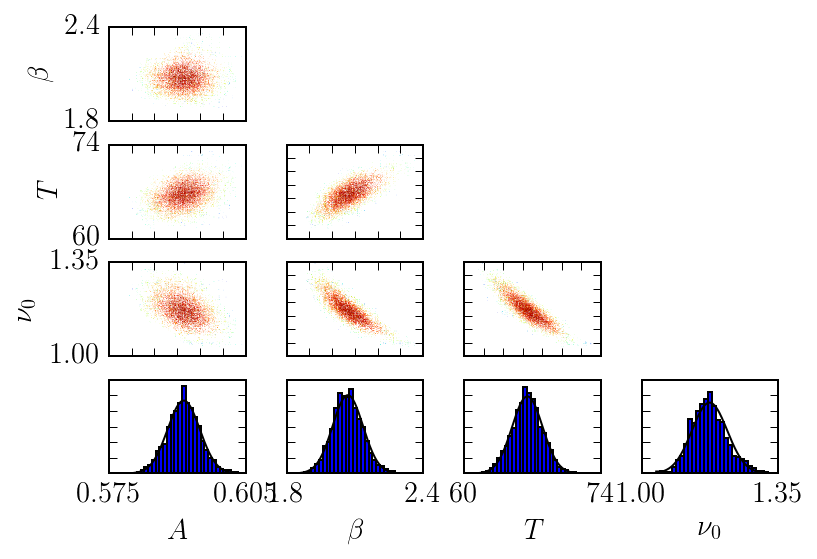

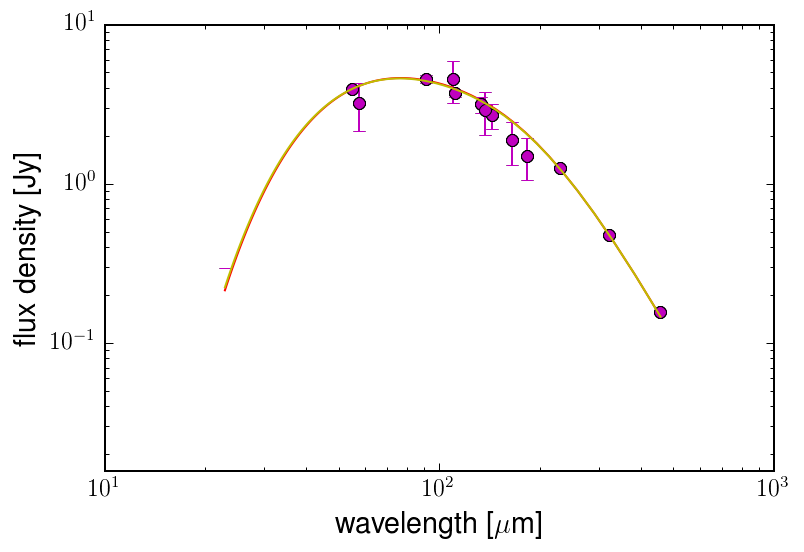

In [3]:
%matplotlib inline
reload(driver)
herus_file = "august6table.csv"
idata = 7
sA, sB, sT, snu = 2, 4, 4, 10   ## was 1,2,2
nMC = (10000, 50000, 50000, 50000)
ret = driver.main(filename=herus_file, i=idata, getNorm=True, sigmas=(sA,sB,sT,snu), retMCMC=True, nMC=nMC,
                  onecomponent=True, opticallyThick=True, fig0=0,  fdir="./", check="./check0.npy", next0=True,
                  random=True, randomrestart=True,linear=True, filetype="DLC_2014")

In [60]:
import getdist

def mcmc2getdist(mcmc):
    """
    Convert an AHJ MCMC object into an A Lewis MCSamples object
    """

    ## only use parameters with proposal width>0 -- otherwise fixed
    params = mcmc.prop.sigmas>0

    samples = mcmc.samples[:,params]
    labels = [t for t,p in zip(mcmc.mod.texNames, params) if p]
    loglikes = -mcmc.lnPr   ### note negative: AL version wants -lnPr
    return getdist.MCSamples(names=labels, samples=samples, loglikes=loglikes, labels=labels)

In [110]:
gds = [mcmc2getdist(m) for m in ret[0]]
labels = [t for t,p in zip(mcmc.mod.texNames, params) if p]
gdall = getdist.MCSamples(names=labels, labels=labels)
gdall.chains = gds
gdall._weightsChanged()
print gdall.makeSingle() is gdall
print gdall.getMeans()
print gdall.getVars()
print gdall.means

True
[  1.70257943e-01   2.73002342e+01   3.34700240e-02   5.76890029e+01]
[  5.42504772e-04   4.63325932e+00   6.55684862e-04   4.89080994e+01]
[  1.70257943e-01   2.73002342e+01   3.34700240e-02   5.76890029e+01]


In [118]:
gdall.getConvergeTests()

'Parameter autocorrelation lengths (effective number of samples N_eff = tot weight/weight length)\n\n            Weight Length   Sample length           N_eff\n$A_1$            7.18E-01            0.72          222886\n$T_1$            3.72E-01            0.37          429792\n$A_2$            7.18E-01            0.72          222924\n$T_2$            5.13E-01            0.51          312100\n\n\nmean convergence stats using remaining chains\nparam sqrt(var(chain mean)/mean(chain var))\n\n$A_1$         0.7607  $A_1$\n$T_1$         2.5841  $T_1$\n$A_2$         0.8676  $A_2$\n$T_2$         1.2766  $T_2$\n\nvar(mean)/mean(var) for eigenvalues of covariance of means of orthonormalized parameters\n  1      0.00000\n  2      0.00238\n  3      0.66713\n  4      4.18985\n\nSplit tests: rms_n([delta(upper/lower quantile)]/sd) n={2,3,4}, limit=95%:\ni.e. mean sample splitting change in the quantiles in units of the st. dev.\n\n$A_1$        0.2082   0.1761   0.1581 upper\n$A_1$        1.2016   1.

[<getdist.chains.WeightedSamples object at 0x10d8ba150>, <getdist.chains.WeightedSamples object at 0x10d8baa90>, <getdist.chains.WeightedSamples object at 0x10d8ba350>, <getdist.chains.WeightedSamples object at 0x10d8ba250>]


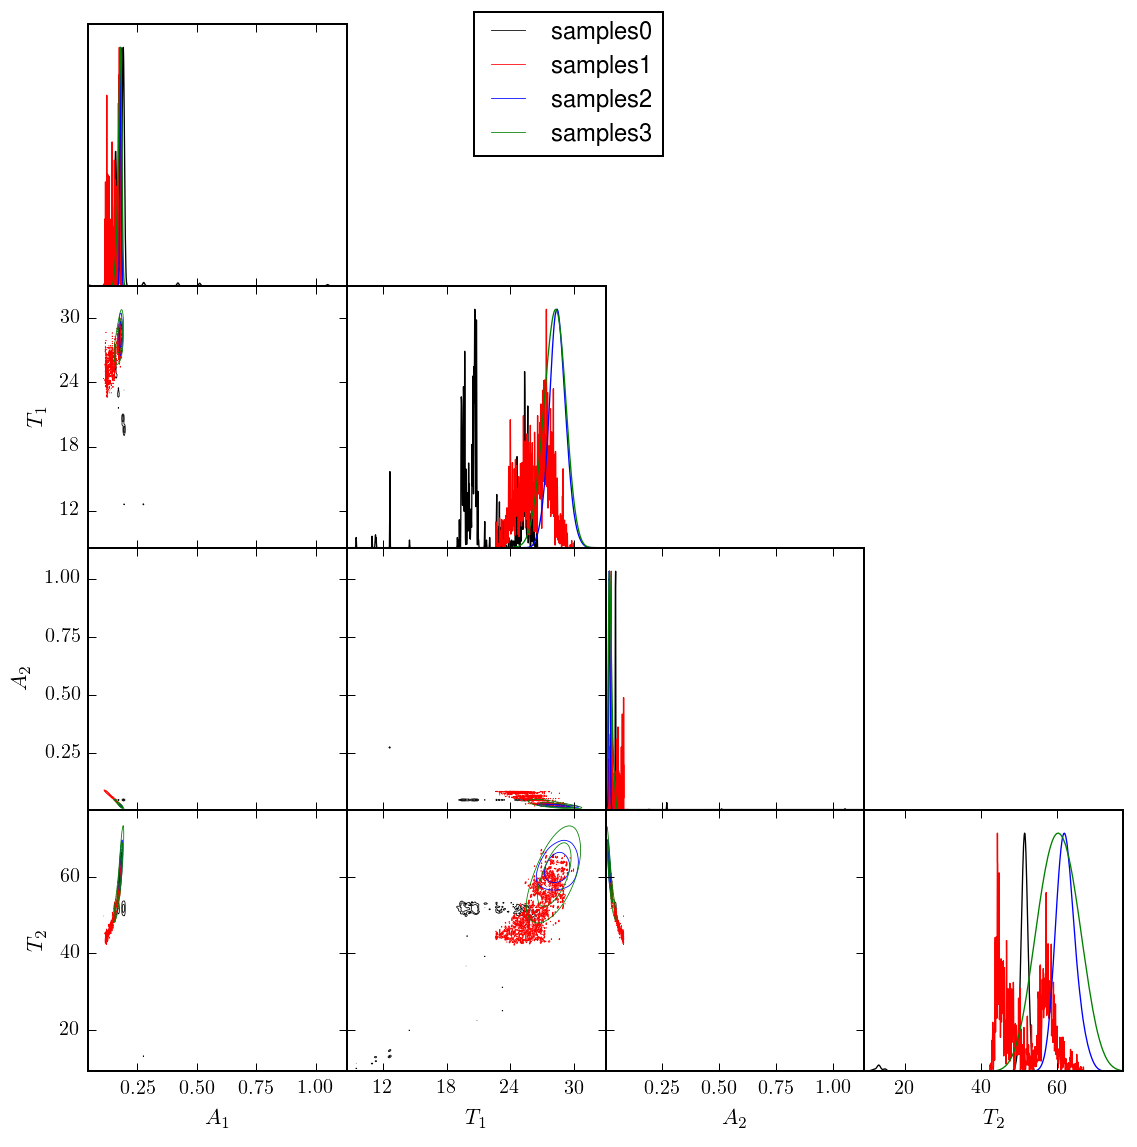

In [116]:
import getdist.plots
g = getdist.plots.getSubplotPlotter()
chains = gdall.getSeparateChains()
print chains
g.triangle_plot(gds)

In [150]:
import convergence
burn=1; stride=1
print convergence.gelmanrubin_MCMC(ret[0][0:], burn, stride)
print convergence.gelmanrubin_MCMC(ret[0][1:], burn, stride)

[ 1.00788605  1.6405586   1.02075079  1.42159596]
[ 1.00587537  1.00361153  1.00623056  1.00104647]
